In [81]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [82]:
cohort = pd.read_csv("../csvs/cohort_clean.csv")

### RQ1. How do early vital signs differ between survivors and non-survivors?

In [83]:
vitals = pd.read_csv("../csvs/vitals_agg.csv") 
vitals_df = vitals.merge(cohort[["subject_id", "mortality_flag"]], on="subject_id", how="inner")

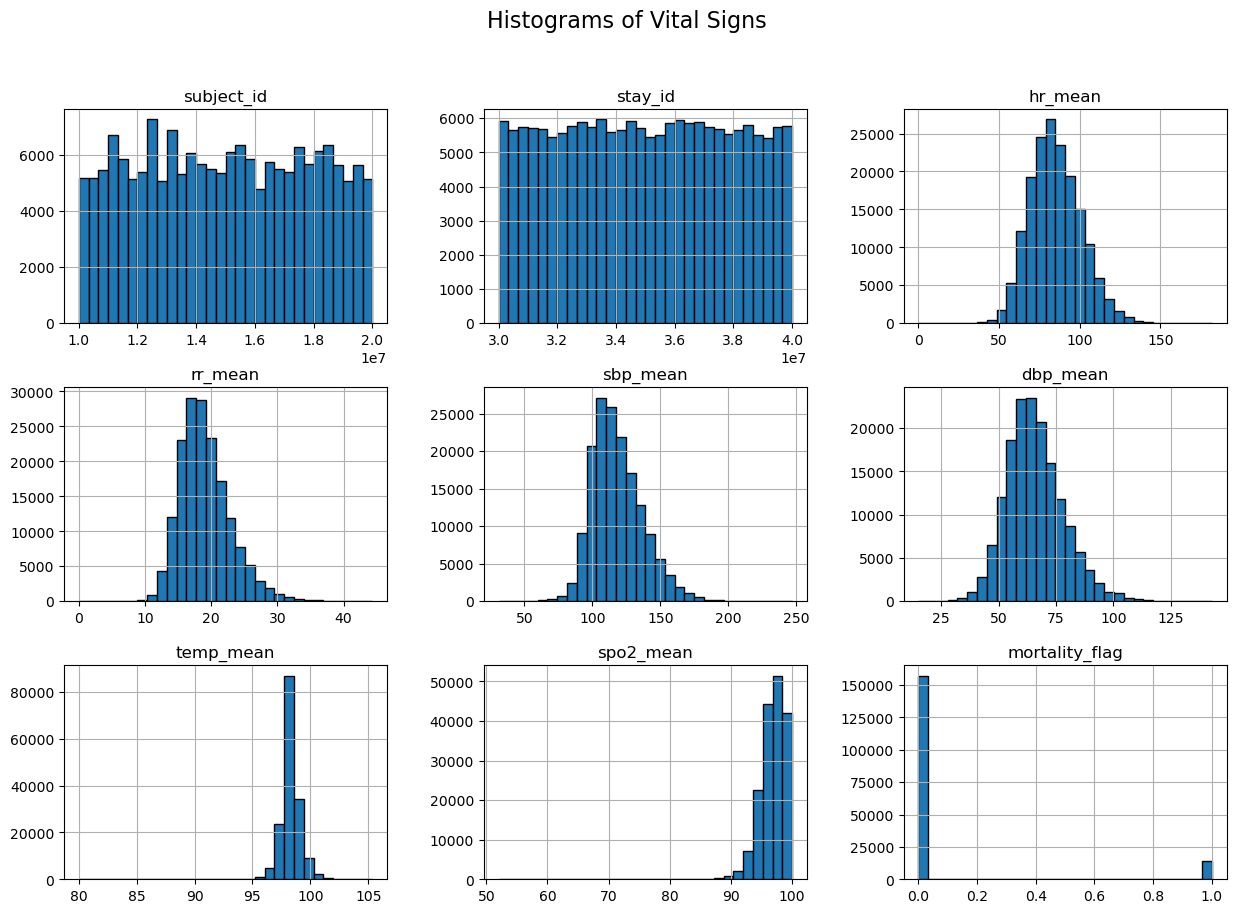

In [84]:
# Seeing the distribution of vital signs helps decide which statistical test to use
vitals_df.hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Histograms of Vital Signs', fontsize=16)
plt.show()

In [85]:
surv = vitals_df.loc[vitals_df["mortality_flag"] == 0].dropna()
nonsurv = vitals_df.loc[vitals_df["mortality_flag"] == 1].dropna()

In [86]:
vital_cols = ['hr_mean', 'rr_mean', 'sbp_mean', 'dbp_mean', 'temp_mean', 'spo2_mean']
results = {}

for col in vital_cols:
    group1 = surv[col]
    group2 = nonsurv[col]
    
    # Using Mann-Whitney U test for non-parametric data
    u_stat, p_value = stats.mannwhitneyu(group1, group2, alternative="two-sided")
    
    results[col] = {
        'U-Statistic': f'{u_stat:.3f}',
        'P-Value': f'{p_value:.5f}',
        'Mean_Survivor': f'{group1.mean():.2f}',
        'Mean_NonSurvivor': f'{group2.mean():.2f}'
    }

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df


,U-Statistic,P-Value,Mean_Survivor,Mean_NonSurvivor
hr_mean,731559472.500,0.00000,84.91,89.04
rr_mean,659681072.500,0.00000,19.01,20.64
sbp_mean,973950141.000,0.00000,118.84,114.14
dbp_mean,981923960.500,0.00000,66.23,62.72
temp_mean,898345395.500,0.00000,98.29,98.21
spo2_mean,909227668.000,0.00000,96.79,96.23


### RQ2. How do early laboratory values differ between survivors and non-survivors?

In [87]:
labs = pd.read_csv("../csvs/labs_agg.csv") 
labs_df = labs.merge(cohort[["subject_id", "mortality_flag"]], on="subject_id", how="inner")

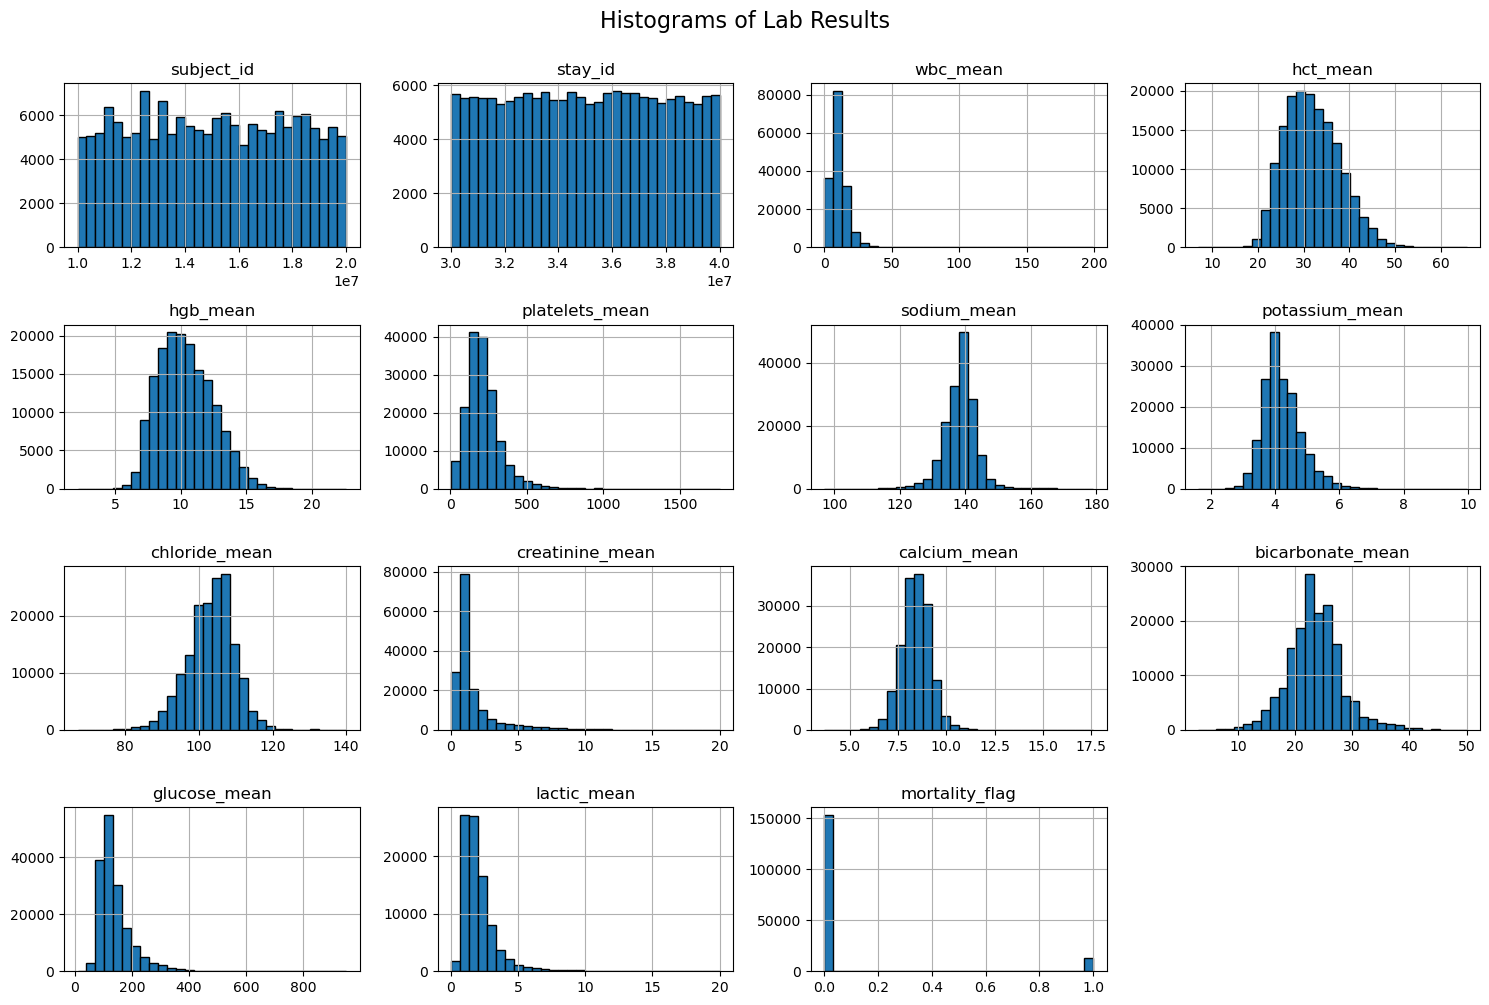

In [88]:
labs_df.hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Histograms of Lab Results', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

In [89]:
surv = labs_df.loc[labs_df["mortality_flag"] == 0].dropna()
nonsurv = labs_df.loc[labs_df["mortality_flag"] == 1].dropna()

In [90]:
labs_cols = ['wbc_mean', 'hct_mean', 'hgb_mean',
       'platelets_mean', 'sodium_mean', 'potassium_mean', 'chloride_mean',
       'creatinine_mean', 'calcium_mean', 'bicarbonate_mean', 'glucose_mean',
       'lactic_mean']
results = {}

for col in labs_cols:
    group1 = surv[col]
    group2 = nonsurv[col]
    
    u_stat, p_value = stats.mannwhitneyu(group1, group2, alternative="two-sided")
    
    results[col] = {
        'U-Statistic': f'{u_stat:.3f}',
        'P-Value': f'{p_value:.5f}',
        'Mean_Survivor': f'{group1.mean():.2f}',
        'Mean_NonSurvivor': f'{group2.mean():.2f}'
    }

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df


,U-Statistic,P-Value,Mean_Survivor,Mean_NonSurvivor
wbc_mean,283369606.000,0.00000,12.24,14.32
hct_mean,335275461.500,0.00000,31.26,31.12
hgb_mean,338104782.500,0.00000,10.13,10.04
platelets_mean,363901610.500,0.00000,209.59,189.80
sodium_mean,317892146.500,0.00027,137.96,138.24
potassium_mean,300867860.000,0.00000,4.26,4.37
chloride_mean,329598966.000,0.05898,103.10,103.01
creatinine_mean,265812338.500,0.00000,1.83,2.06
calcium_mean,348325916.000,0.00000,8.31,8.24
bicarbonate_mean,392808202.500,0.00000,22.84,20.92


### RQ3. Which variables show the strongest association with mortality?

In [91]:
vitals_labs = vitals_df.merge(labs_df[["subject_id"] + labs_cols], on="subject_id", how="inner")
all_cols = vital_cols + labs_cols

In [92]:
surv = vitals_labs.loc[vitals_labs["mortality_flag"] == 0].dropna()
nonsurv = vitals_labs.loc[vitals_labs["mortality_flag"] == 1].dropna()

In [93]:
# cohen's D calculation for effect size
def cohen_d(group1, group2):    
  mean_diff = group1.mean() - group2.mean()
  pooled_std = np.sqrt(((len(group1) - 1) * group1.std()**2 + (len(group2) - 1) * group2.std()**2) / (len(group1) + len(group2) - 2))
  return mean_diff / pooled_std

In [94]:
effect_sizes = {}

for col in all_cols:
  group1 = surv[col]
  group2 = nonsurv[col]
  cohen_d_value = cohen_d(group1, group2)
  effect_sizes[col] = {
    'Cohen\'s D': f'{cohen_d_value:.2f}'
  }

effect_sizes_df = pd.DataFrame.from_dict(effect_sizes, orient='index')
effect_sizes_df = effect_sizes_df.sort_values(by='Cohen\'s D', ascending=False)
effect_sizes_df

,Cohen's D
platelets_mean,0.56
glucose_mean,0.27
hr_mean,0.16
spo2_mean,0.08
sbp_mean,0.07
dbp_mean,0.04
wbc_mean,0.04
sodium_mean,-0.28
rr_mean,-0.27
bicarbonate_mean,-0.27


In [95]:
# filter by d value greater than 0.2 or less than -0.2 for small to medium effect size
effect_sizes_df = effect_sizes_df[abs(effect_sizes_df['Cohen\'s D'].astype(float)) > 0.2]
effect_sizes_df

,Cohen's D
platelets_mean,0.56
glucose_mean,0.27
sodium_mean,-0.28
rr_mean,-0.27
bicarbonate_mean,-0.27


### RQ4. How does ICU length of stay differ between survivors and non-survivors?

In [96]:
surv = cohort.loc[vitals_labs["mortality_flag"] == 0].dropna()
nonsurv = cohort.loc[vitals_labs["mortality_flag"] == 1].dropna()

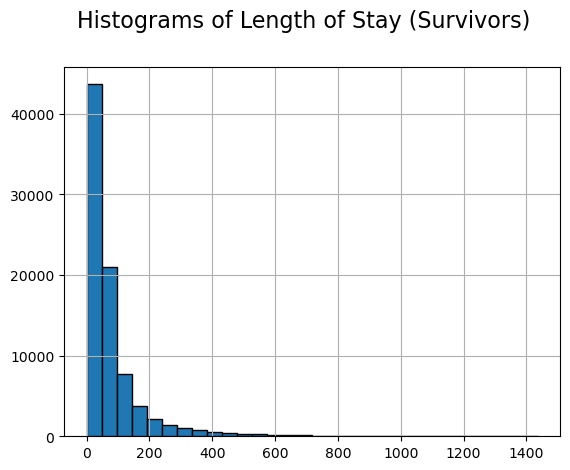

In [97]:
surv['los_hours'].hist(bins=30, edgecolor='black')
plt.suptitle('Histograms of Length of Stay (Survivors)', fontsize=16, y=1.00)
plt.show()

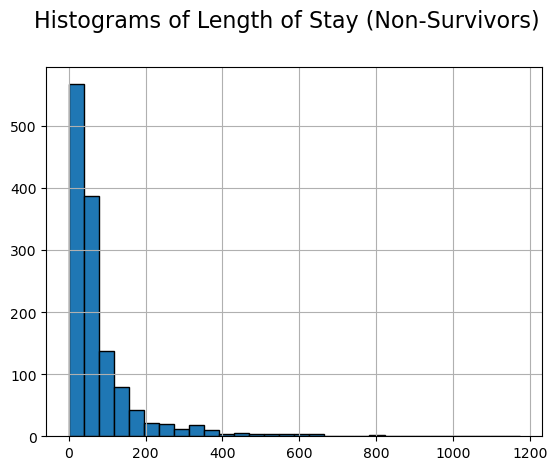

In [98]:
nonsurv['los_hours'].hist(bins=30, edgecolor='black')
plt.suptitle('Histograms of Length of Stay (Non-Survivors)', fontsize=16, y=1.00)
plt.show()

In [99]:
# mann-whitney u test for length of stay
u_stat, p_value = stats.mannwhitneyu(surv['los_hours'], nonsurv['los_hours'], alternative="two-sided")
print(f'U-Statistic: {u_stat:.3f}, P-Value: {p_value:.5f}') 

# cohen's D calculation for effect size for length of stay
cohen_d_value = cohen_d(surv['los_hours'], nonsurv['los_hours'])
print(f'Cohen\'s D: {cohen_d_value:.2f}')

U-Statistic: 55767930.000, P-Value: 0.88713
Cohen's D: 0.01
